In [50]:
import pandas as pd
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [51]:
df_1bed_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_1_bed_flat_monetary_2013-2021.csv')
bed_2_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_flat_monetary_2013-2021.csv')
bed_2_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_house_monetary_2013-2021.csv')
bed_3_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_flat_monetary_2013-2021.csv')
bed_3_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_house_monetary_2013-2021.csv')
bed_4_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_4_house_monetary_2013-2021.csv')

In [3]:
df_1bed_flat

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2021,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019,Offence_Count_2020,Offence_Count_2021
0,298,$330,300,$330,320,$320,325,$320,328,$320,...,"5,265.30","11,054","11,364","11,915","12,733","13,427","12,549","12,778","12,965","13,408"
1,180,$305,178,$300,171,$300,173,$300,168,$300,...,"4,398.30","8,603","9,444","9,958","10,204","11,484","10,191","10,501","12,090","11,635"
2,70,$310,70,$310,60,$310,58,$310,56,$313,...,"6,229.20","33,752",890,"33,707","35,452","37,315","36,659","35,626","36,359","35,712"
3,"2,280",$320,"2,293",$320,"2,277",$325,"2,231",$325,"2,367",$329,...,"6,229.20","33,752",890,"33,707","35,452","37,315","36,659","35,626","36,359","35,712"
4,"3,322",$380,"3,522",$380,"3,700",$380,"3,904",$380,"4,045",$375,...,"5,265.30","11,054","11,364","11,915","12,733","13,427","12,549","12,778","12,965","13,408"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,14,$250,15,$250,18,$240,17,$230,15,$250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,72,$140,84,$140,78,$140,77,$140,82,$148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,-,-,-,-,-,-,-,-,-,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,80,$160,87,$160,91,$160,83,$170,87,$175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_1bed_flat_no_covid =pd.read_csv('../data/curated/Rental_Price_historical/joined_1_bed_flat_monetary_2013-2019.csv')
bed_2_flat_no_covid=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_flat_monetary_2013-2019.csv')
bed_2_house_no_covid=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_house_monetary_2013-2019.csv')
bed_3_flat_no_covid=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_flat_monetary_2013-2019.csv')
bed_3_house_no_covid=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_house_monetary_2013-2019.csv')
bed_4_house_no_covid=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_4_house_monetary_2013-2019.csv')

# Prediction
The features are:
1. Median_age_persons 
2. Median_mortgage_repay_monthly
3. Median_tot_prsnl_inc_weekly
4. Average_household_size
5. Population
6. Alleged Offender Incident Rate
7. Victimization Rate
8. Offender Count

In [53]:
def get_forecast_all_suburbs(raw_df, yrs, PRED_COL):
    # cols_imputed = {}
    forecasted_data = {}
    for index, row in raw_df.iterrows():
        X_df = make_2D(row, yrs, PRED_COL)


        forecasted_data[row['Suburb']] = forecast(X_df)


    return forecasted_data

def make_2D(suburb_row, yrs, PRED_COL):
    cols_imputed = {}
    X_df = {}
    for feature in PRED_COL:
        f = []
        for t in suburb_row.iteritems():
            if feature in t[0]:
                f.append(t[1])
        X_df[feature] = f

    X_df = pd.DataFrame.from_dict(X_df)
    X_df.loc[:,'year'] = yrs
    X_df.rename(columns = {"Median_Mar":"Median_rental_price"}, inplace = True)
    
    for col in X_df:
        year = []
        data = []
        if col != 'year':
            for i in range(0,len(yrs)):
                if (X_df.loc[i,col] != -1):
                    data.append(X_df.loc[i,col])
                    year.append(yrs[i]) 
            if (len(year) == 0):
                continue   
            df = pd.DataFrame()     
            df["year"]=year
            df["data"]=data 
            reg = LinearRegression().fit(df[["year"]], df["data"])
            
            arr = []
            for yr in yrs:
                arr.extend(reg.predict(np.array([[yr]])))
    #                     print(arr)
        cols_imputed[col] = arr


    for i in range(0,len(yrs)):
        for col in cols_imputed:
            if (X_df.loc[i,col] == -1):
                X_df.loc[i,col] = cols_imputed[col][i]

    return X_df


def forecast(X_df):
    future_yrs = [2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030]
    reg_forecast = pd.DataFrame()
    for col in X_df.iloc[:, 1:-1]:
        l = []
        reg = LinearRegression().fit(X_df['year'].values.reshape((-1,1)), X_df[col].values.reshape((-1,1)))
        for yr in future_yrs:
            l.extend(reg.predict(np.array([[yr]])))
            row = [np.round(x[0], 1) for x in l]
    #         print(l)
        reg_forecast[col] = row
    reg_forecast['year'] = future_yrs
    regr = make_pipeline(StandardScaler(), SVR(kernel='poly', C=3, epsilon=0.2))

    regr.fit(X_df.iloc[:,[1,2,3,7,8,9,10,11]], X_df['Median_rental_price'])
    future_price = regr.predict(reg_forecast.iloc[:,[0,1,2,6,7,8,9,10]])

    
    
#     print(reg_forecast.iloc[:,[0,1,2,6]])
    # Median_age_persons, Median_mortgage_repay_monthly, Median_tot_prsnl_inc_weekly, Average_household_size
    
    reg_forecast["Median_rental_price"] = future_price
    # reg = LinearRegression().fit(X_df.iloc[:,[1,2,3,7]], X_df['Median_rental_price'])

    # future_price = reg.predict(reg_forecast.iloc[:,[0,1,2,6]])
    # reg_forecast["Median_rental_price"] = future_price
    return reg_forecast

In [54]:
import warnings
warnings.filterwarnings('ignore')

#### Prediction

In [208]:
bed_4_house.nunique()

Count_Mar2013         103
Median_Mar2013         69
Count_Jun2013         102
Median_Jun2013         79
Count_Sep2013         101
                     ... 
Offence_Count_2017     29
Offence_Count_2018     29
Offence_Count_2019     29
Offence_Count_2020     29
Offence_Count_2021     29
Length: 168, dtype: int64

In [209]:
bed_4_house

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2021,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019,Offence_Count_2020,Offence_Count_2021
0,35,"$1,100",40,"$1,125",32,"$1,150",38,"$1,125",41,"$1,050",...,"5,265.30","11,054","11,364","11,915","12,733","13,427","12,549","12,778","12,965","13,408"
1,15,"$1,175",14,"$1,138",12,"$1,200",13,"$1,300",11,"$1,200",...,"4,398.30","8,603","9,444","9,958","10,204","11,484","10,191","10,501","12,090","11,635"
2,11,$900,14,$888,13,$880,12,$850,17,$850,...,"6,229.20","33,752",890,"33,707","35,452","37,315","36,659","35,626","36,359","35,712"
3,37,$800,28,$819,34,$820,28,$850,31,$850,...,"6,229.20","33,752",890,"33,707","35,452","37,315","36,659","35,626","36,359","35,712"
4,-,-,-,-,-,-,-,-,-,-,...,"5,265.30","11,054","11,364","11,915","12,733","13,427","12,549","12,778","12,965","13,408"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,152,$450,152,$450,150,$450,130,$460,145,$460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,117,$350,133,$350,147,$350,155,$350,154,$350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,99,$335,102,$330,106,$340,102,$340,108,$340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,183,$380,183,$390,185,$395,179,$390,181,$380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
def impute_missing(df, impute_value, pred_cols):
    for col in df:
        df[col] = df[col].replace("-",impute_value)
        for pred_col in pred_cols:
            if pred_col in col:
                df[col] = df[col].replace({'\$':''}, regex = True)
                df[col] = df[col].replace(",","", regex=True)
                df[col] = df[col].astype(float)
    return df

In [56]:
df_1bed_flat = impute_missing(df_1bed_flat, "-1", pred_cols)
bed_2_flat = impute_missing(bed_2_flat, "-1", pred_cols)
bed_2_house = impute_missing(bed_2_house, "-1", pred_cols)
bed_3_flat = impute_missing(bed_3_flat, "-1", pred_cols)
bed_3_house = impute_missing(bed_3_house, "-1", pred_cols)
bed_4_house = impute_missing(bed_4_house, "-1", pred_cols)

In [10]:
df_1bed_flat

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2021,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019,Offence_Count_2020,Offence_Count_2021
0,298,330.0,300,$330,320,$320,325,$320,328,320.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
1,180,305.0,178,$300,171,$300,173,$300,168,300.0,...,4398.3,8603.0,9444.0,9958.0,10204.0,11484.0,10191.0,10501.0,12090.0,11635.0
2,70,310.0,70,$310,60,$310,58,$310,56,313.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
3,"2,280",320.0,"2,293",$320,"2,277",$325,"2,231",$325,"2,367",329.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
4,"3,322",380.0,"3,522",$380,"3,700",$380,"3,904",$380,"4,045",375.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,14,250.0,15,$250,18,$240,17,$230,15,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,72,140.0,84,$140,78,$140,77,$140,82,148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,80,160.0,87,$160,91,$160,83,$170,87,175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
df_1bed_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Columns: 168 entries, Count_Mar2013 to Offence_Count_2021
dtypes: float64(108), int64(1), object(59)
memory usage: 190.4+ KB


In [57]:
yrs = [2013,2014,2015,2016,2017,2018,2019, 2020, 2021]



df_1bed_flat_w_pop_cleaned = df_1bed_flat.dropna()
bed_2_flat_w_pop_cleaned = bed_2_flat.dropna()
bed_2_house_w_pop_cleaned = bed_2_house.dropna()
bed_3_flat_w_pop_cleaned = bed_3_flat.dropna()
bed_3_house_w_pop_cleaned = bed_3_house.dropna()
bed_4_house_w_pop_cleaned = bed_4_house.dropna()

In [14]:
bed_2_flat_w_pop_cleaned

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2021,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019,Offence_Count_2020,Offence_Count_2021
0,255,450.0,266,$450,256,$450,268,$450,264,450.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
1,264,395.0,276,$395,287,$395,305,$395,328,395.0,...,4398.3,8603.0,9444.0,9958.0,10204.0,11484.0,10191.0,10501.0,12090.0,11635.0
2,99,415.0,103,$420,105,$415,105,$410,105,400.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
3,951,455.0,947,$455,969,$455,965,$456,"1,045",460.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
4,"2,900",520.0,"2,973",$520,"3,050",$520,"3,097",$520,"3,369",520.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,195,250.0,209,$250,206,$250,210,$250,198,250.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0
106,744,260.0,763,$260,741,$260,765,$260,755,265.0,...,3319.1,13223.0,890.0,14402.0,15288.0,16647.0,14308.0,14787.0,14942.0,14157.0
107,220,260.0,237,$260,235,$260,239,$262,226,260.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0
108,275,300.0,261,$300,262,$300,258,$310,253,310.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0


In [58]:
df_1bed_flat_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_1_bed_flat_monetary_2013-2021_cleaned.csv', index = False)
bed_2_flat_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_bed_2_flat_monetary_2013-2021_cleaned.csv', index = False)
bed_2_house_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_bed_2_house_monetary_2013-2021_cleaned.csv', index = False)
bed_3_flat_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_bed_3_flat_monetary_2013-2021_cleaned.csv', index = False)
bed_3_house_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_bed_3_house_monetary_2013-2021_cleaned.csv', index = False)
bed_4_house_w_pop_cleaned.to_csv('../data/curated/Rental_Price_historical/joined_bed_4_house_monetary_2013-2021_cleaned.csv', index = False)

In [59]:
df_1bed_flat_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_1_bed_flat_monetary_2013-2021_cleaned.csv')
bed_2_flat_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_flat_monetary_2013-2021_cleaned.csv')
bed_2_house_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_house_monetary_2013-2021_cleaned.csv')
bed_3_flat_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_flat_monetary_2013-2021_cleaned.csv')
bed_3_house_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_house_monetary_2013-2021_cleaned.csv')
bed_4_house_w_pop_cleaned = pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_4_house_monetary_2013-2021_cleaned.csv')

In [60]:
df_1bed_flat_w_pop_cleaned

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2021,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019,Offence_Count_2020,Offence_Count_2021
0,298,330.0,300,$330,320,$320,325,$320,328,320.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
1,180,305.0,178,$300,171,$300,173,$300,168,300.0,...,4398.3,8603.0,9444.0,9958.0,10204.0,11484.0,10191.0,10501.0,12090.0,11635.0
2,70,310.0,70,$310,60,$310,58,$310,56,313.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
3,"2,280",320.0,"2,293",$320,"2,277",$325,"2,231",$325,"2,367",329.0,...,6229.2,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0,36359.0,35712.0
4,"3,322",380.0,"3,522",$380,"3,700",$380,"3,904",$380,"4,045",375.0,...,5265.3,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0,12965.0,13408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,40,198.0,41,$220,34,$220,31,$220,23,230.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0
90,158,190.0,167,$200,199,$200,226,$200,248,210.0,...,3319.1,13223.0,890.0,14402.0,15288.0,16647.0,14308.0,14787.0,14942.0,14157.0
91,22,240.0,20,$240,17,$240,24,$205,21,194.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0
92,24,218.0,27,$215,33,$215,31,$220,27,220.0,...,2243.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0,11317.0,10774.0


In [31]:
pred_cols = ['Median_Mar', 'Median_age_persons', 'Median_mortgage_repay_monthly', 'Median_tot_prsnl_inc_weekly', 
             'Median_rent_weekly', 'Median_tot_fam_inc_weekly','Average_num_psns_per_bedroom', 
             'Average_household_size', 'Pop', 'Alleged_Offender_Incident_Rate', 'Victimisation_Rate', 'Offence_Count']

In [32]:
forecast_bed_1_flat_covid = get_forecast_all_suburbs(df_1bed_flat_w_pop_cleaned, yrs, pred_cols)
forecast_bed_2_flat_covid = get_forecast_all_suburbs(bed_2_flat_w_pop_cleaned, yrs, pred_cols)
forecast_bed_2_house_covid = get_forecast_all_suburbs(bed_2_house_w_pop_cleaned, yrs, pred_cols)
forecast_bed_3_flat_covid = get_forecast_all_suburbs(bed_3_flat_w_pop_cleaned, yrs, pred_cols)
forecast_bed_3_house_covid = get_forecast_all_suburbs(bed_3_house_w_pop_cleaned, yrs, pred_cols)
forecast_bed_4_house_covid = get_forecast_all_suburbs(bed_4_house_w_pop_cleaned, yrs, pred_cols)

In [222]:
bed_2_house_w_pop_cleaned.loc[:,['Suburb', 'Postcode']].to_csv('../data/curated/sub_4_pred.csv')

In [33]:
forecast_bed_4_house_covid[bed_4_house.loc[5,'Suburb']]

,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Average_household_size,Pop,Alleged_Offender_Incident_Rate,Victimisation_Rate,Offence_Count,year,Median_rental_price
0,32.8,2170.5,1259.2,423.4,2688.7,1.0,1.9,8464.0,3747.7,6583.3,14030.4,2020,796.417948
1,32.9,2170.1,1321.1,436.5,2800.4,1.0,1.9,8637.3,3760.2,6557.6,14375.1,2021,800.375301
2,33.0,2169.6,1382.9,449.6,2912.1,1.0,1.9,8810.5,3772.6,6531.9,14719.9,2022,806.180891
3,33.1,2169.2,1444.8,462.7,3023.9,1.0,1.9,8983.7,3785.0,6506.2,15064.6,2023,814.245743
4,33.2,2168.8,1506.7,475.7,3135.6,0.9,1.9,9157.0,3797.4,6480.4,15409.4,2024,824.920061
5,33.3,2168.3,1568.6,488.8,3247.3,0.9,1.9,9330.2,3809.8,6454.7,15754.1,2025,838.494201
6,33.5,2167.9,1630.5,501.9,3359.1,0.9,1.9,9503.4,3822.2,6429.0,16098.9,2026,858.789601
7,33.6,2167.5,1692.4,515.0,3470.8,0.9,1.8,9676.7,3834.6,6403.3,16443.6,2027,928.119986
8,33.7,2167.0,1754.2,528.1,3582.5,0.9,1.8,9849.9,3847.0,6377.6,16788.4,2028,961.404054
9,33.8,2166.6,1816.1,541.2,3694.3,0.8,1.8,10023.1,3859.4,6351.8,17133.1,2029,999.900648


#### Prediction without Covid

In [261]:
df_1bed_flat_no_covid = impute_missing(df_1bed_flat_no_covid, "-1", pred_cols)
bed_2_flat_no_covid = impute_missing(bed_2_flat_no_covid, "-1", pred_cols)
bed_2_house_no_covid = impute_missing(bed_2_house_no_covid, "-1", pred_cols)
bed_3_flat_no_covid = impute_missing(bed_3_flat_no_covid, "-1", pred_cols)
bed_3_house_no_covid = impute_missing(bed_3_house_no_covid, "-1", pred_cols)
bed_4_house_no_covid = impute_missing(bed_4_house_no_covid, "-1", pred_cols)

In [262]:
df_1bed_flat_no_covid_w_pop_cleaned = df_1bed_flat_no_covid.dropna()
bed_2_flat_no_covid_w_pop_cleaned = bed_2_flat_no_covid.dropna()
bed_2_house_no_covid_w_pop_cleaned = bed_2_house_no_covid.dropna()
bed_3_flat_no_covid_w_pop_cleaned = bed_3_flat_no_covid.dropna()
bed_3_house_no_covid_w_pop_cleaned = bed_3_house_no_covid.dropna()
bed_4_house_no_covid_w_pop_cleaned = bed_4_house_no_covid.dropna()

In [258]:
df_1bed_flat_no_covid_w_pop_cleaned

,Count_Mar2013,Median_Mar2013,Count_Jun2013,Median_Jun2013,Count_Sep2013,Median_Sep2013,Count_Dec2013,Median_Dec2013,Count_Mar2014,Median_Mar2014,...,Victimisation_Rate_2017,Victimisation_Rate_2018,Victimisation_Rate_2019,Offence_Count_2013,Offence_Count_2014,Offence_Count_2015,Offence_Count_2016,Offence_Count_2017,Offence_Count_2018,Offence_Count_2019
0,298,330.0,300,$330,320,$320,325,$320,328,320.0,...,6388.3,5620.4,5442.8,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0
1,180,305.0,178,$300,171,$300,173,$300,168,300.0,...,4981.9,4054.0,4181.7,8603.0,9444.0,9958.0,10204.0,11484.0,10191.0,10501.0
2,70,310.0,70,$310,60,$310,58,$310,56,313.0,...,8583.0,7697.4,7129.8,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0
3,"2,280",320.0,"2,293",$320,"2,277",$325,"2,231",$325,"2,367",329.0,...,8583.0,7697.4,7129.8,33752.0,890.0,33707.0,35452.0,37315.0,36659.0,35626.0
4,"3,322",380.0,"3,522",$380,"3,700",$380,"3,904",$380,"4,045",375.0,...,6388.3,5620.4,5442.8,11054.0,11364.0,11915.0,12733.0,13427.0,12549.0,12778.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,40,198.0,41,$220,34,$220,31,$220,23,230.0,...,2988.4,2889.8,2694.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0
106,158,190.0,167,$200,199,$200,226,$200,248,210.0,...,4489.1,3743.5,4061.1,13223.0,890.0,14402.0,15288.0,16647.0,14308.0,14787.0
107,22,240.0,20,$240,17,$240,24,$205,21,194.0,...,2988.4,2889.8,2694.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0
108,24,218.0,27,$215,33,$215,31,$220,27,220.0,...,2988.4,2889.8,2694.2,9154.0,9922.0,10231.0,11427.0,11745.0,11023.0,10875.0


In [263]:
forecast_bed_1_flat_no_covid = get_forecast_all_suburbs(df_1bed_flat_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)
forecast_bed_2_flat_no_covid = get_forecast_all_suburbs(bed_2_flat_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)
forecast_bed_2_house_no_covid = get_forecast_all_suburbs(bed_2_house_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)
forecast_bed_3_flat_no_covid = get_forecast_all_suburbs(bed_3_flat_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)
forecast_bed_3_house_no_covid = get_forecast_all_suburbs(bed_3_house_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)
forecast_bed_4_house_no_covid = get_forecast_all_suburbs(bed_4_house_no_covid_w_pop_cleaned, yrs[0:7], pred_cols)

In [264]:
forecast_bed_4_house_no_covid[bed_4_house.loc[0,'Suburb']]

,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Average_household_size,Pop,Alleged_Offender_Incident_Rate,Victimisation_Rate,Offence_Count,year,Median_rental_price
0,36.2,1986.2,1171.2,381.0,2662.7,1.0,1.7,3907.7,2761.2,5800.5,13553.4,2020,865.245461
1,36.6,1974.1,1197.6,385.1,2716.9,1.0,1.7,3919.2,2702.7,5816.0,13876.8,2021,875.408881
2,37.0,1962.0,1224.0,389.2,2771.1,1.0,1.7,3930.7,2644.2,5831.5,14200.1,2022,889.349104
3,37.4,1949.9,1250.4,393.3,2825.3,1.0,1.7,3942.2,2585.7,5847.1,14523.5,2023,907.668713
4,37.8,1937.8,1276.8,397.4,2879.5,0.9,1.7,3953.7,2527.2,5862.6,14846.9,2024,930.960305
5,38.2,1925.7,1303.2,401.5,2933.7,0.9,1.7,3965.2,2468.7,5878.1,15170.2,2025,959.824576
6,38.6,1913.6,1329.6,405.6,2987.9,0.9,1.7,3976.7,2410.2,5893.7,15493.6,2026,994.867970
7,39.0,1901.5,1356.0,409.7,3042.1,0.9,1.7,3988.2,2351.7,5909.2,15816.9,2027,1036.675748
8,39.4,1889.4,1382.4,413.8,3096.3,0.9,1.7,3999.7,2293.2,5924.7,16140.3,2028,1085.853591
9,39.8,1877.3,1408.8,417.9,3150.5,0.8,1.6,4011.2,2234.7,5940.3,16463.6,2029,1271.614113


# Analysis

In [61]:
CORR_COLS = ['Median_rental_price', 'Median_age_persons', 'Median_mortgage_repay_monthly', 'Median_tot_prsnl_inc_weekly', 'Median_tot_fam_inc_weekly','Average_num_psns_per_bedroom', 
             'Average_household_size']

In [77]:
def get_corr_avg_med(raw_df, yrs, pred_cols):
    plot_df = pd.DataFrame()

    for feature in CORR_COLS:
        df = pd.DataFrame()
        for i, row in raw_df.iterrows():
            rw = make_2D(row, yrs, pred_cols)
            df[str(i)] = rw[feature]
        avg_df = df.mean()
        plot_df[feature] = avg_df.values
        
    return plot_df

In [80]:
df_1bed_flat_corr = get_corr_avg_med(df_1bed_flat_w_pop_cleaned, yrs, pred_cols)
bed_2_flat_corr = get_corr_avg_med(bed_2_flat_w_pop_cleaned, yrs, pred_cols)
bed_2_house_corr = get_corr_avg_med(bed_2_house_w_pop_cleaned, yrs, pred_cols)
bed_3_flat_corr = get_corr_avg_med(bed_3_flat_w_pop_cleaned, yrs, pred_cols)
bed_3_house_corr = get_corr_avg_med(bed_3_house_w_pop_cleaned, yrs, pred_cols)
bed_4_house_corr = get_corr_avg_med(bed_4_house_w_pop_cleaned, yrs, pred_cols)

In [75]:
df_1bed_flat_w_pop_cleaned['Postcode'].value_counts()

3182    3
3056    2
3188    2
3032    1
3076    1
       ..
3149    1
3101    1
3150    1
3122    1
3197    1
Name: Postcode, Length: 90, dtype: int64

In [84]:
liveable_features = pd.read_csv('../data/curated/liveability.csv')
liveable_features

,Unnamed: 0,Suburb,Postcode,NumParks,NumShoppingCentres,NumSchool,DstToStation
0,0,"St Kilda, St Kilda South, St Kilda West",3182,9,3,5,1444.0
1,1,"Armadale North, Armadale",3143,0,0,2,307.7
2,2,"Carlton South, Carlton",3053,3,0,2,1978.0
3,3,"Melbourne University, Parkville",3052,3,0,3,1139.4
4,4,"St Kilda, St Kilda South, St Kilda West",3182,9,3,5,1444.0
...,...,...,...,...,...,...,...
89,89,"Dromana, Arthurs Seat, Safety Beach",3936,1,1,3,21947.4
90,90,"Karingal Centre, Karingal, Frankston Heights, ...",3199,17,3,20,2250.4
91,91,"Tuerong, Hastings",3915,2,0,4,8203.2
92,92,Mornington,3931,15,3,7,13918.4


In [86]:
liveable_features.iloc[:,3:7]

,NumParks,NumShoppingCentres,NumSchool,DstToStation
0,9,3,5,1444.0
1,0,0,2,307.7
2,3,0,2,1978.0
3,3,0,3,1139.4
4,9,3,5,1444.0
...,...,...,...,...
89,1,1,3,21947.4
90,17,3,20,2250.4
91,2,0,4,8203.2
92,15,3,7,13918.4


In [88]:
df_1bed_flat_corr = df_1bed_flat_corr.join(liveable_features.iloc[:,3:7])

<AxesSubplot:>

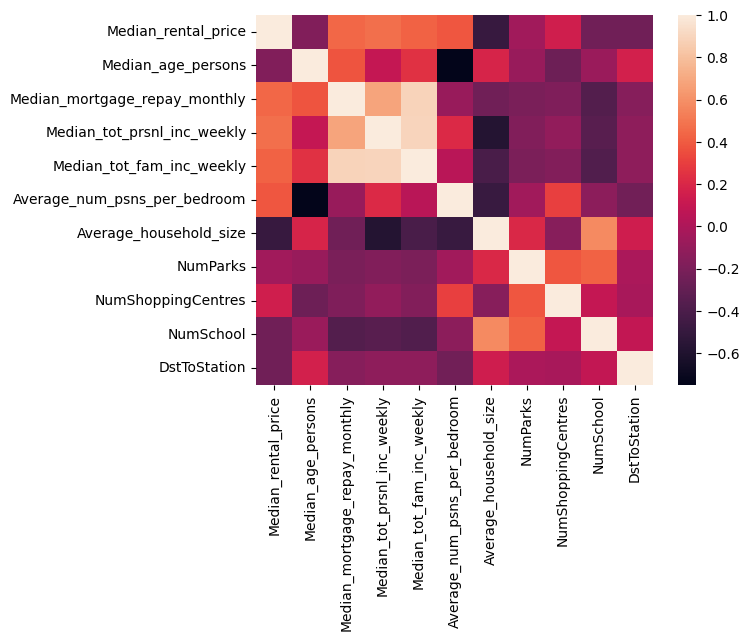

In [91]:
sns.heatmap(df_1bed_flat_corr.corr())

In [ ]:
df_1bed_flat_corr.corr().to_csv("../data/curated/corr/bed_1_flat_corr.csv")
bed_2_flat_corr.corr().to_csv("../data/curated/corr/bed_2_flat_corr.csv")
bed_2_house_corr.corr().to_csv("../data/curated/corr/bed_2_house_corr.csv")
bed_3_flat_corr.corr().to_csv("../data/curated/corr/bed_3_flat_corr.csv")
bed_3_house_corr.corr().to_csv("../data/curated/corr/bed_3_house_corr.csv")
bed_4_house_corr.corr().to_csv("../data/curated/corr/bed_4_house_corr.csv")

In [ ]:
avg_df = plot_df.iloc[:, :143].mean()
avg_df.sort_values(ascending = False)    

In [ ]:
avg_df.values

In [ ]:
sns.lineplot(plot_df.iloc[:, 133], yrs)

In [ ]:
sns.lineplot(x='year', y='value', hue='variable', data=pd.melt(plot_df, ['year']), legend=False)

In [ ]:
df_1bed_flat.sort_values("Median_Mar2012", ascending=False)

# Aggregate by Victoria

In [138]:
agg_yrs = [2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

In [139]:
df_1bed_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_1_bed_flat_monetary_2011-2021.csv')
bed_2_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_flat_monetary_2011-2021.csv')
bed_2_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_2_house_monetary_2011-2021.csv')
bed_3_flat=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_flat_monetary_2011-2021.csv')
bed_3_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_3_house_monetary_2011-2021.csv')
bed_4_house=pd.read_csv('../data/curated/Rental_Price_historical/joined_bed_4_house_monetary_2011-2021.csv')

In [140]:
df_1bed_flat_new = impute_missing(df_1bed_flat, np.nan, pred_cols[:9])
bed_2_flat_new = impute_missing(bed_2_flat, np.nan, pred_cols[:9])
bed_2_house_new = impute_missing(bed_2_house, np.nan, pred_cols[:9])
bed_3_flat_new = impute_missing(bed_3_flat, np.nan, pred_cols[:9])
bed_3_house_new = impute_missing(bed_3_house, np.nan, pred_cols[:9])
bed_4_house_new = impute_missing(bed_4_house, np.nan, pred_cols[:9])

In [142]:
df_1bed_flat_new = df_1bed_flat_new.dropna()
bed_2_flat_new = bed_2_flat_new.dropna()
bed_2_house_new = bed_2_house_new.dropna()
bed_3_flat_new = bed_3_flat_new.dropna()
bed_3_house_new = bed_3_house_new.dropna()
bed_4_house_new = bed_4_house_new.dropna()

In [86]:
def get_avg_by_year(df, yrs, pred_cols):
    avg = {}
    for i,rw in df.iterrows():
        X_df = make_2D(rw, yrs, pred_cols)
        for j,row in X_df.iterrows():
            if row['year'] in avg.keys():
                avg[row['year']] += row['Median_rental_price']
            else:
                avg[row['year']] = row['Median_rental_price']
           
    avg = {x: avg[x]/df.shape[0] for x in avg}
    return avg

In [87]:
df_1bed_flat_avg_by_yr = get_avg_by_year(df_1bed_flat_new, agg_yrs, pred_cols[:9])
bed_2_flat_avg_by_yr = get_avg_by_year(bed_2_flat_new, agg_yrs, pred_cols[:9])
bed_2_house_avg_by_yr = get_avg_by_year(bed_2_house_new, agg_yrs, pred_cols[:9])
bed_3_flat_avg_by_yr = get_avg_by_year(bed_3_flat_new, agg_yrs, pred_cols[:9])
bed_3_house_avg_by_yr = get_avg_by_year(bed_3_house_new, agg_yrs, pred_cols[:9])
bed_4_house_avg_by_yr = get_avg_by_year(bed_4_house_new, agg_yrs, pred_cols[:9])

In [162]:
bed_4_house_avg_by_yr

{2011.0: 519.2446808510638,
 2012.0: 551.9148936170212,
 2013.0: 552.2765957446809,
 2014.0: 574.7978723404256,
 2015.0: 596.8191489361702,
 2016.0: 610.1489361702128,
 2017.0: 632.7553191489362,
 2018.0: 651.2978723404256,
 2019.0: 666.6063829787234,
 2020.0: 676.5,
 2021.0: 661.1170212765958}

In [148]:
def get_avg_by_year_pred(forecast_dict, df):
    pred_dict ={}
    for sub in forecast_dict.keys():
        if sub in df.loc[:,'Suburb'].tolist():
    #         print(forecast_bed_4_house_covid[sub])
            curr_df = forecast_dict[sub]
            for j,row in curr_df.iterrows():
                if row['year'] in pred_dict.keys():
                    pred_dict[row['year']] += row['Median_rental_price']
                else:
                    pred_dict[row['year']] = row['Median_rental_price']

    pred_dict = {x: pred_dict[x]/df.shape[0] for x in pred_dict}
    return pred_dict

In [154]:
df_1bed_flat_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_1_flat_covid , df_1bed_flat_new )
bed_2_flat_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_2_flat_covid , bed_2_flat_new )
bed_2_house_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_2_house_covid , bed_2_house_new )
bed_3_flat_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_3_flat_covid , bed_3_flat_new )
bed_3_house_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_3_house_covid , bed_3_house_new )
bed_4_house_avg_by_yr_pred = get_avg_by_year_pred(forecast_bed_4_house_covid , bed_4_house_new )

df_1bed_flat_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_1_flat_no_covid , df_1bed_flat_new )
bed_2_flat_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_2_flat_no_covid , bed_2_flat_new )
bed_2_house_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_2_house_no_covid , bed_2_house_new )
bed_3_flat_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_3_flat_no_covid , bed_3_flat_new )
bed_3_house_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_3_house_no_covid , bed_3_house_new )
bed_4_house_avg_by_yr_pred_no_covid = get_avg_by_year_pred(forecast_bed_4_house_no_covid , bed_4_house_new )

In [168]:
bed_4_house_avg_by_yr_pred

{2020.0: 629.8205045880368,
 2021.0: 636.6425627155332,
 2022.0: 647.3584720350995,
 2023.0: 663.0424593491741,
 2024.0: 688.1282938985233,
 2025.0: 717.0492221149786,
 2026.0: 758.0296639137746,
 2027.0: 810.1285272313926,
 2028.0: 866.9443646518424,
 2029.0: 947.5028315715125,
 2030.0: 1032.1148347492312}

In [174]:
bed_4_house_avg_by_yr_pred_no_covid

{2020.0: 641.2317532510817,
 2021.0: 670.3642106033965,
 2022.0: 713.065745716878,
 2023.0: 772.9530511924006,
 2024.0: 865.0557501237739,
 2025.0: 966.1260507070225,
 2026.0: 1096.8259528870658,
 2027.0: 1255.1144801239357,
 2028.0: 1438.357166293543,
 2029.0: 1681.6429897204027,
 2030.0: 1953.0667733907328}